## Base model construction and training
This notebook includes importing and unpacking data that have been preprocessed for model training and training a single CNN model. Additional models or model adjustments - including exposure to augmented training data - will be performed in separate notebooks.

Spectrograms have already been **standardized** (standard-scaler within each array, not across whole dataset), **reshaped**, and train-test-splat in prior notebook. This format is due to memory limitations: training the model on all data at once continuosly broke.  As such, I have broken the whole into 9 chunks and will train the model(s) with each subset sequentially. Train-test subsets will be deleted before importing the next one to free up as much memory as possible. Overkill? Yes. But better than a dead kernel partway through fitting. The code below begins with importing the subsets, already standardized, already divided into train-test splits with consistent pos:neg ratios. Import formats are lists of tuples: (spectrogram_array , label).  

The architecture for this base model is based on that of deep learning networks used for marine mammal acoustics in several sources. These sources were operating with data of different volumes, from different environments, and often to different ends (ie multiclass classification, or dealing with species functioning in entirely different frequency ranges). Thus, no network from prior literature is ready 'out of the box' for this project, but they are a better starting point than completely winging it.

EDIT: kernel still dies upon fitting second or third subset. Reducing model complexity to run to completion here, but with heavily downsampled data _and_ shallow network, impressive results not expected. See results from AWS for results on higher resolution data.

---
#### Spoiler Results
Base model did not converge. Whether due to loop-fitting, or reduced complexity of data and model to be determined.  Tune in next time.

---
Sources guiding CNN structure:  
* [Padovese et al. 2021.](https://asa.scitation.org/doi/full/10.1121/10.0004258) Data augmentation for the classification of North Atlantic right whales upcalls. _Journal of the Acoustical Society of America_ 149:4.
* [Thomas et al. 2019.](https://ecmlpkdd2019.org/downloads/paper/314.pdf) Marine Mammal Species Classification using CNN and a Novel Acoustic Representation. 
* [Shiu et al. 2020.](https://www.nature.com/articles/s41598-020-57549-y) Deep neural networks for automated detection of marine mammal species. _Nature: Scientific Reports_ 10:607.
* I did not look up correct citation format, please send all complaints to https://github.com/charles-rice

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import gc

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, \
                            accuracy_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler

import random
random.seed(42)

In [2]:
#import data, assign pos/neg
in_path = '../scratch_data/tts_chunked_sm/'
files = os.listdir(in_path)
files

['ch5_test.pkl',
 'ch4_test.pkl',
 'ch7_train.pkl',
 'ch1_train.pkl',
 'ch6_train.pkl',
 'ch8_test.pkl',
 'ch2_test.pkl',
 'ch3_test.pkl',
 'ch0_train.pkl',
 'ch8_train.pkl',
 'ch5_train.pkl',
 'ch6_test.pkl',
 'ch7_test.pkl',
 'ch3_train.pkl',
 'ch1_test.pkl',
 'ch0_test.pkl',
 'ch4_train.pkl',
 'ch2_train.pkl']

In [3]:
with open (in_path+'ch0_train.pkl', mode = 'rb') as f:
    ch0_train = pickle.load(f)
with open (in_path+'ch0_test.pkl', mode = 'rb') as j:
    ch0_test = pickle.load(j)

In [4]:
X_train0, y_train0 = list(zip(*ch0_train))
X_train0 = np.array(X_train0)
y_train0 = np.array(y_train0)
print(type(X_train0), X_train0.shape)
print(type(y_train0), y_train0.shape)

<class 'numpy.ndarray'> (1875, 307, 460, 1)
<class 'numpy.ndarray'> (1875,)


In [5]:
X_test0, y_test0 = list(zip(*ch0_test))
X_test0 = np.array(X_test0)
y_test0 = np.array(y_test0)
print(type(X_test0), X_test0.shape)
print(type(y_test0), y_test0.shape)

<class 'numpy.ndarray'> (625, 307, 460, 1)
<class 'numpy.ndarray'> (625,)


In [6]:
print(pd.Series(y_train0).value_counts(normalize=True))
print(pd.Series(y_test0).value_counts(normalize=True))

0    0.749867
1    0.250133
dtype: float64
0    0.7504
1    0.2496
dtype: float64


In [7]:
#function to speed up future chunks

def pkl_to_CNN(train_file, test_file):
    with open (in_path+train_file, mode = 'rb') as f:
        temp_train = pickle.load(f)
    with open (in_path+test_file, mode = 'rb') as j:
        temp_test = pickle.load(j)
        
    X_train, y_train = list(zip(*temp_train))
    X_test, y_test = list(zip(*temp_test))

    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

#### Model architecture
Basic LeNet construction, preceded by a Conv2D layer with a larger filter and stride to reduce dimensions quickly.

In [8]:
# 3 x convolutional layers with max pooling
cnn = Sequential()
cnn.add(Conv2D(filters = 8, 
               kernel_size=(11,11),
               strides = (4,4), #kernel_size and stride from AlexNet
               activation='relu', 
               input_shape=(307, 460, 1),
               padding = 'valid')) #no padding
cnn.add(MaxPooling2D(pool_size = (3,3), strides=(2,2)))

cnn.add(Conv2D(filters= 16, 
              kernel_size=(5,5), #LeNet uses 2xconv2d with 5x5 kernel, 2x2 pooling
              activation='relu')) #default strides =1
cnn.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))
        
cnn.add(Conv2D(filters = 16,
               kernel_size = (5,5),
               activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))  #output dim = 6 x 11 x 16 = 1056

cnn.add(Flatten())

# 2 x hidden layers w dropout and weight decay
#input nodes = # features
cnn.add(Dense(1056, activation='relu', kernel_regularizer=l2(.001))) 
cnn.add(Dropout(.2)) #double regularization to mitigate overfitting
cnn.add(Dense(128, activation = 'relu', kernel_regularizer=l2(.001)))
cnn.add(Dropout(.2))
cnn.add(Dense(1, activation='sigmoid')) #output layer binary classification

In [9]:
# compile model
cnn.compile(loss = 'binary_crossentropy', optimizer='Adam', 
            metrics=['acc', 'Recall', 'Precision'])

In [10]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 113, 8)        976       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 56, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 52, 16)        3216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 26, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 22, 16)        6416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 11, 16)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1056)              0

In [11]:
#add earlystop?
early_stop = EarlyStopping(patience = 10)

#### Fit model
Verbose at first bc the feedback is helpful to know if things are progressing. Not enacting early_stop because want model trained on all subsets equally. Small batches seems to help with memory demands.

In [12]:
history = cnn.fit(X_train0, y_train0,
                  batch_size=64,
                  validation_data = (X_test0, y_test0),
                  epochs = 100)

Epoch 1/100
30/30 [==============================] - 11s 342ms/step - loss: 1.8840 - acc: 0.7248 - recall: 0.0864 - precision: 0.3329 - val_loss: 1.8571 - val_acc: 0.7504 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/100
30/30 [==============================] - 9s 315ms/step - loss: 1.8655 - acc: 0.7453 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.8571 - val_acc: 0.7504 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/100
30/30 [==============================] - 10s 319ms/step - loss: 1.8339 - acc: 0.7607 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.8571 - val_acc: 0.7504 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/100
30/30 [==============================] - 10s 320ms/step - loss: 1.8472 - acc: 0.7504 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.8571 - val_acc: 0.7504 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/100
30/30 [==============================] - 10s 320ms/step - loss: 1.828

30/30 [==============================] - 11s 365ms/step - loss: 6.3951 - acc: 0.7519 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 3.6164 - val_acc: 0.7504 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 37/100
30/30 [==============================] - 11s 362ms/step - loss: 8.3950 - acc: 0.7625 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 10.2863 - val_acc: 0.7504 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 38/100
30/30 [==============================] - 11s 372ms/step - loss: 6.2408 - acc: 0.7452 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 5.4612 - val_acc: 0.7504 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 39/100
30/30 [==============================] - 12s 398ms/step - loss: 3.5190 - acc: 0.7644 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 3.5909 - val_acc: 0.7504 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 40/100
30/30 [==============================] - 11s 368ms/step - loss: 5.4

30/30 [==============================] - 11s 370ms/step - loss: 3.9484 - acc: 0.7401 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 25.7603 - val_acc: 0.7504 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 72/100
30/30 [==============================] - 11s 367ms/step - loss: 57.6813 - acc: 0.7497 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 4.1837 - val_acc: 0.7504 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 73/100
30/30 [==============================] - 11s 374ms/step - loss: 3.9768 - acc: 0.7534 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 3.9214 - val_acc: 0.7504 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 74/100
30/30 [==============================] - 11s 372ms/step - loss: 3.5551 - acc: 0.7587 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 3.6463 - val_acc: 0.7504 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 75/100
30/30 [==============================] - 11s 375ms/step - loss: 4.

In [13]:
del X_train0, y_train0, X_test0, y_test0
gc.collect()

2042

One subset success without memory overload. Just predicting majority class the whole time - no surprise it couldn't pull nuances out of such small subset, check back at the end.  Looping the rest, verbose=0.

In [14]:
for i in range(1,9):
    
    X_train, X_test, y_train, y_test = pkl_to_CNN(f'ch{i}_train.pkl', f'ch{i}_test.pkl')

    history = cnn.fit(X_train, y_train,
                      batch_size=64,
                      validation_data = (X_test, y_test),
                      epochs = 100, verbose=0)
    print(f'chunk {i} of 8 fit')

chunk 1 of 8 fit
chunk 2 of 8 fit
chunk 3 of 8 fit
chunk 4 of 8 fit
chunk 5 of 8 fit
chunk 6 of 8 fit
chunk 7 of 8 fit
chunk 8 of 8 fit


#### Visualize

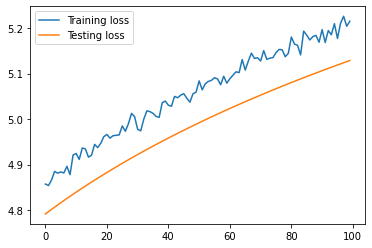

In [18]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Testing loss')
plt.legend();

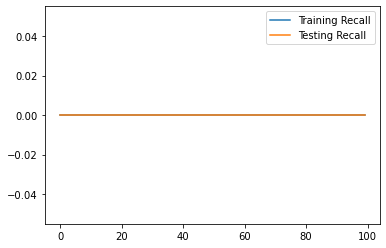

In [19]:
#priority metric = recall: minimize false negatives
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Testing Recall')
plt.legend();

In [17]:
# history.history

In [20]:
with open ('../data/models/01_hist_cnn_base_sm.pkl', mode = 'wb') as f:
    pickle.dump(history.history, f)